In [460]:
import json
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Preprocess

## base

In [461]:
df = pd.read_parquet("labeled_post.parquet")

In [462]:
df = df.loc[df.link_flair_text.isin([
    'Asshole',
    'Asshole POO Mode',
    'Everyone Sucks',
    'Everyone Sucks POO Mode',
    'Mega Asshole',
    'No A-holes here',
    'Not the A-hole',
    'Not the A-hole POO Mode',
])]

In [463]:
len(df)

78588

In [464]:
df = df.loc[~df.selftext.isin([
    '[deleted]',
    '[removed]'
])]

In [465]:
len(df)

74699

## add topic

In [485]:
df_topic = pd.read_csv("topic/df_output.csv")

In [486]:
len(df_topic)

74700

In [487]:
# diff
# set(df_topic.id) - set(df.id)

In [488]:
keywords = []
for topic_keywords in df_topic[['Name', 'Representation']].drop_duplicates().Representation.apply(lambda x: eval(x)).tolist():
    keywords += topic_keywords

In [489]:
# check if keywords in Representation column are duplicated among topics
# if length not match, duplicated
len(keywords), len(set(keywords))

(550, 417)

In [490]:
keywords = set(keywords)

In [491]:
df_topic = pd.concat([df_topic, pd.get_dummies(df_topic.Name, dtype=int)], axis=1)

In [493]:
df_topic_ohe = pd.DataFrame(
    {
        keyword: df_topic['Representation'].apply(lambda x: 1 if keyword in x else 0)
        for keyword in keywords
    }
)

In [494]:
df_topic = pd.concat([df_topic, df_topic_ohe], axis=1)

In [496]:
df_topic = df_topic.drop(columns=['Unnamed: 0', 'Topic', 'Count', 'Name', 'Representation'])

In [497]:
# df_topic['Name'] = df_topic.Name.apply(lambda x: ' '.join(x.split('_')[1:]))
# df_topic['Representation'] = df_topic.Representation.apply(lambda x: ' '.join(eval(x)))

In [498]:
df_topic

,id,-1_parents_upset_stay_later,0_friendship_talk_bf_upset,10_classroom_students_assignments_semester,11_gifts_presents_gift card_secret santa,12_debt_savings_spending_afford,13_boss_employee_coworkers_shifts,14_weight loss_eating disorder_diet_fat,15_smoking weed_smoker_cigarettes_apartment,16_speak spanish_racism_conversation_native,...,cigarettes,eating disorder,savings,queen,niece,years,notes,mum,gave,meeting
0,1284npp,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1284q84,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1284sqm,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1284trz,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,128509j,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74695,18pnieb,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74696,18pno1q,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74697,18pnoev,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74698,18pnp6m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [499]:
df = df.merge(df_topic, on='id')

In [500]:
len(df)

74699

## add verdict label

In [501]:
flairs = {
    'Asshole': 'YTA',
    'Asshole POO Mode': 'YTA',
    'Everyone Sucks': 'YTA',
    'Everyone Sucks POO Mode': 'YTA',
    'Mega Asshole': 'YTA',
    'No A-holes here': 'NTA',
    'Not the A-hole': 'NTA',
    'Not the A-hole POO Mode': 'NTA',
}

In [502]:
df = df.loc[df.link_flair_text.isin(flairs)].copy()
df['verdict'] = df.link_flair_text.map(flairs)

df["is_asshole"] = 0
df.loc[df.verdict == "YTA", "is_asshole"] = 1

df = df.reset_index().sort_values(by="index")

In [503]:
len(df)

74699

## add linguistic

In [504]:
df_ling = pd.read_parquet("labeled_post_features.parquet")[[
    'id',
    'demonyms',
    'demonyms_words_count',
    'demonyms_unique_count',
    'features',
    'title_uppercase_count',
    'title_word_count',
    'title_profanity_count',
    'avg_word_length',
    'stop_word_count',
    'numerics_count',
    'uppercase_words_count',
    'sentence_count',
    'avg_sentence_length',
    'profanity_count',
]]

In [505]:
df = df.merge(df_ling, on="id")

In [506]:
len(df)

74699

## add gender and age

In [507]:
# load llama output
df_llama = pd.concat([
    pd.read_parquet("labeled_post_llama_prompt.parquet"),
    pd.read_parquet("labeled_post_llama_prompt2.parquet")
])

llama_output = []
for part in range(1, 6):
    with open(f"llama-genage/results-unknown-10k-part{part}.json") as f:
        llama_output += json.load(f)

for part in range(1, 5):
    with open(f"llama-genage/results-unknown-10k-part2-{part}.json") as f:
        llama_output += json.load(f)

# remove prompt from llama outputs
df_llama['llama_output'] = llama_output
df_llama['llama_gender_age'] = df_llama.apply(
    lambda x: x['llama_output'][len(x['prompt']):], axis=1)

In [508]:
# parse llama output
def parse_llama_gender_age(gender_age):
    if ',' not in gender_age:
        return None, None

    s = gender_age.split(',')
    age_raw = s[0].strip()
    gender_raw = s[1].strip().lower()

    age = None
    gender = None
    
    try:
        if 15 < int(age_raw) < 80:
            age = int(age_raw)
        else:
            age = None
    except (ValueError, TypeError):
        age = None

    if gender_raw == "female":
        gender = "F"
    elif gender_raw == "male":
        gender = "M"

    return age, gender


df_llama['llama_age'] = df_llama.llama_gender_age.apply(lambda x: parse_llama_gender_age(x)[0])
df_llama['llama_gender'] = df_llama.llama_gender_age.apply(lambda x: parse_llama_gender_age(x)[1])

df_gen = pd.read_parquet("labeled_post_genage.parquet")[["id", "link_flair_text", "gender", "age"]]
df_gen = df_gen.merge(df_llama[["id", "llama_gender", "llama_age"]], left_on="id", right_on="id")
df_gen = df_gen.loc[df_gen.link_flair_text.isin(flairs)].copy()

In [509]:
# not null rate
len(df_gen.loc[df_gen.gender.notnull()]) / len(df_gen), len(df_gen.loc[df_gen.age.notnull()]) / len(df_gen)

(0.5886539269481966, 0.4610233363463913)

In [510]:
df_gen.loc[df_gen.gender.isna(), 'gender'] = df_gen.llama_gender
df_gen.loc[df_gen.age.isna(), 'age'] = df_gen.llama_age

In [511]:
# not null rate: after comlpement by llama
len(df_gen.loc[df_gen.gender.notnull()]) / len(df_gen), len(df_gen.loc[df_gen.age.notnull()]) / len(df_gen)

(0.6490636179612207, 0.5323946172355405)

In [512]:
df_gen.gender = df_gen.gender.fillna("U")
one_hot_encoded = pd.get_dummies(df_gen['gender'], prefix='gender')
df_gen = pd.concat([df_gen, one_hot_encoded], axis=1)

In [513]:
df = df.merge(df_gen, on="id")

In [514]:
len(df)

74658

## add sentiment

In [515]:
df_sent = pd.read_parquet("labeled_post_sentiment-analysis-pysentimiento.parquet")[["id", "selftext_probas", "title_probas"]]
df_sent_title = df_sent.title_probas.apply(pd.Series).add_prefix("title_")
df_sent = pd.concat([df_sent.drop(columns=['title_probas']), df_sent_title], axis=1)
df_sent_selftext = df_sent.selftext_probas.apply(pd.Series).add_prefix("selftext_")
df_sent = pd.concat([df_sent.drop(columns=['selftext_probas']), df_sent_selftext], axis=1)

In [516]:
# plt.figure(figsize=(8, 6))
# sns.boxplot(data=df_sent)
# plt.xticks(rotation=90)
# plt.show()

In [517]:
df = df.merge(df_sent, on="id")

In [518]:
len(df)

74658

## save

In [519]:
df.to_parquet("labeled_post_enriched.parquet")

In [520]:
# df.to_parquet("labeled_post_enriched_bert.parquet")

In [521]:
df.head(1).T

,0
index,0
link_flair_text_x,Not the A-hole
num_comments,1155
over_18,False
score,9597
...,...
selftext_fear,0.002371
selftext_joy,0.024384
selftext_others,0.96449
selftext_sadness,0.003151


# LightGBM

In [522]:
# # load processed data
# df = pd.read_parquet("labeled_post_enriched.parquet")

In [523]:
df.is_asshole.value_counts()

is_asshole
0    58565
1    16093
Name: count, dtype: int64

In [524]:
min_samples = min(df.is_asshole.value_counts())

df_use = pd.concat([
    df.loc[df.is_asshole == 0][:min_samples],
    df.loc[df.is_asshole == 1][:min_samples],
])

In [525]:
len(df_use)

32186

In [622]:
X = df_use[[
    # 'index',
    # 'link_flair_text',
    # 'num_comments',
    # 'over_18',
    # 'score',
    # 'url',
    # 'selftext',
    # 'title',
    # 'id',
    # 'edited',
    # 'is_self',
    # 'permalink',
    # 'downs',
    # 'ups',
    # 'created',
    # 'date',
    # 'demonyms',

    # ================================================================
    # topic
    # ================================================================
    '-1_parents_upset_stay_later',
    '0_friendship_talk_bf_upset',
    '10_classroom_students_assignments_semester',
    '11_gifts_presents_gift card_secret santa',
    '12_debt_savings_spending_afford',
    '13_boss_employee_coworkers_shifts',
    '14_weight loss_eating disorder_diet_fat',
    '15_smoking weed_smoker_cigarettes_apartment',
    '16_speak spanish_racism_conversation_native',
    '17_buy car_old car_cars_insurance',
    '18_finances_mortgage_savings_rent',
    '19_baby names_naming_nicknames_family',
    '1_pets_barking_litter_walk',
    '20_grandparents_funeral_aunt_upset',
    '21_seats_bus_flight attendant_wheelchair',
    '22_cutting hair_curly hair_hairstyle_shave head',
    '23_taking pictures_facebook_wedding_media',
    '24_chores_daycare_nap_pregnant',
    '25_going church_pastor_catholic_pray',
    '26_family_brother_relationship_bf',
    '27_dress_dress code_want wear_fashion',
    '28_noise complaint_noises_neighbors_quiet hours',
    '29_xbox_gift_macbook_nintendo switch',
    '2_wedding party_engagement_bridesmaids_bridal',
    '30_assigned parking_parking spaces_street parking_car parked',
    '31_bedroom_share room_sleep couch_air mattress',
    '32_transphobic_trans_lgbtq_family',
    '33_clean room_chores_laundry_cleaning',
    '34_mum_mental health_relationship_abusive',
    '35_sell tickets_concert tickets_pay ticket_ticketmaster',
    '36_dress wedding_white dress_bridesmaids_dress code',
    '37_matching tattoos_want tattoo_got tattoo_arm',
    '38_gifts_gift card_anniversary_spend',
    '39_bf_parents_dating_situation',
    '3_debt_afford_income_savings',
    '40_engagement ring_wedding rings_fiancé_engagement',
    '41_painting_sketches_artists_hobby',
    '42_lend_owes_debt_gambling',
    '43_left lane_traffic_turning_honking',
    '44_fence property_neighbors_backyard_hedge',
    '45_sing_band_concert_choir',
    '46_sleeping_wakes_morning_set alarm',
    '47_siblings_mom_relationship_upset',
    '48_affair_best friend_married_jim',
    '49_payment_waiter_discount_drinks',
    '4_custody_pregnancy_stay_upset',
    '50_varsity_teammates_volleyball_tournament',
    '51_watch shows_wants watch_started watching_watching movie',
    '52_brothers_step brother_family_behavior',
    '53_pools_children_lifeguard_snorkeling',
    '5_meals_eats_foods_dish',
    '6_thanksgiving_holidays_celebrate_dinner',
    '7_roommate_cleaning_chores_bathroom',
    '8_stepdad_parents_siblings_divorce',
    '9_roommate_landlord_lease_pay rent',

    # ================================================================
    # topic keywords
    # ================================================================
    *keywords,
    
    # ================================================================
    # linguistic
    # ================================================================
    'demonyms_words_count',
    'demonyms_unique_count',
    'title_uppercase_count',
    'title_word_count',
    'title_profanity_count',
    'avg_word_length',
    'stop_word_count',
    'numerics_count',
    'uppercase_words_count',
    'sentence_count',
    'avg_sentence_length',
    'profanity_count',

    # ================================================================
    # demography
    # ================================================================
    'age',
    'gender_F',
    'gender_M',
    'gender_U',

    # ================================================================
    # sentiment
    # ================================================================
    'title_anger',
    'title_disgust',
    'title_fear',
    'title_joy',
    'title_others',
    'title_sadness',
    'title_surprise',
    'selftext_anger',
    'selftext_disgust',
    'selftext_fear',
    'selftext_joy',
    'selftext_others',
    'selftext_sadness',
    'selftext_surprise',
]].copy()

In [623]:
X.shape

(32186, 502)

In [624]:
y = df_use.is_asshole

In [625]:
# full -> train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# train -> train, val
# 0.8 x 0.25 = 0.2
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, shuffle=True
)

train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
val_data = lgb.Dataset(X_val, label=y_val, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, free_raw_data=False)

In [626]:
train_data.save_binary('train.bin')
val_data.save_binary('val.bin')
test_data.save_binary('test.bin')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] File train.bin exists, cannot save binary to it
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] File val.bin exists, cannot save binary to it
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] File test.bin exists, cannot save binary to it


In [627]:
param = {
    'num_leaves': 31,
    'objective': 'binary'
}

In [628]:
num_round = 1000
# bst = lgb.train(param, train_data, num_round, valid_sets=[val_data])
bst = lgb.train(param, train_data, num_round)

[LightGBM] [Info] Number of positive: 9669, number of negative: 9642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5634
[LightGBM] [Info] Number of data points in the train set: 19311, number of used features: 502
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500699 -> initscore=0.002796
[LightGBM] [Info] Start training from score 0.002796


In [629]:
# lgb.cv(param, train_data, num_round, nfold=5)

In [630]:
# bst = lgb.train(param, train_data, num_round, valid_sets=valid_sets, callbacks=[lgb.early_stopping(stopping_rounds=5)])

In [631]:
ypred = bst.predict(X_test, num_iteration=bst.best_iteration)

In [632]:
ypred_labels = np.where(ypred >= 0.5, 1, 0)

In [633]:
ypred_labels[:100]

array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [634]:
y_test.values[:100]

array([1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1])

In [635]:
cm = confusion_matrix(y_test, ypred_labels)
TN, FP, FN, TP = cm.ravel()
print(f'True Positives (TP): {TP}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')
print(f'True Negatives (TN): {TN}')

True Positives (TP): 1814
False Positives (FP): 1404
False Negatives (FN): 1392
True Negatives (TN): 1828


In [636]:
print(classification_report(y_test, ypred_labels))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57      3232
           1       0.56      0.57      0.56      3206

    accuracy                           0.57      6438
   macro avg       0.57      0.57      0.57      6438
weighted avg       0.57      0.57      0.57      6438



#### topic, topic keywords, linguistic, demographic, sentiment

```
              precision    recall  f1-score   support

           0       0.57      0.57      0.57      3232
           1       0.56      0.57      0.56      3206

    accuracy                           0.57      6438
   macro avg       0.57      0.57      0.57      6438
weighted avg       0.57      0.57      0.57      6438
```

### topic

```
              precision    recall  f1-score   support

           0       0.53      0.74      0.62      3232
           1       0.56      0.33      0.41      3206

    accuracy                           0.54      6438
   macro avg       0.54      0.53      0.51      6438
weighted avg       0.54      0.54      0.51      6438
```

### topic keywords

```
              precision    recall  f1-score   support

           0       0.53      0.74      0.62      3232
           1       0.56      0.33      0.41      3206

    accuracy                           0.54      6438
   macro avg       0.54      0.53      0.51      6438
weighted avg       0.54      0.54      0.51      6438
```

#### linguistic

```
              precision    recall  f1-score   support

           0       0.53      0.52      0.52      3232
           1       0.52      0.52      0.52      3206

    accuracy                           0.52      6438
   macro avg       0.52      0.52      0.52      6438
weighted avg       0.52      0.52      0.52      6438
```

#### demography

```
              precision    recall  f1-score   support

           0       0.57      0.47      0.52      3232
           1       0.55      0.64      0.59      3206

    accuracy                           0.56      6438
   macro avg       0.56      0.56      0.55      6438
weighted avg       0.56      0.56      0.55      6438
```

#### sentiment

```
              precision    recall  f1-score   support

           0       0.52      0.53      0.53      3232
           1       0.52      0.51      0.52      3206

    accuracy                           0.52      6438
   macro avg       0.52      0.52      0.52      6438
weighted avg       0.52      0.52      0.52      6438
```


In [541]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)

/Users/thama/Downloads/Reddit/reddit/.venv/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


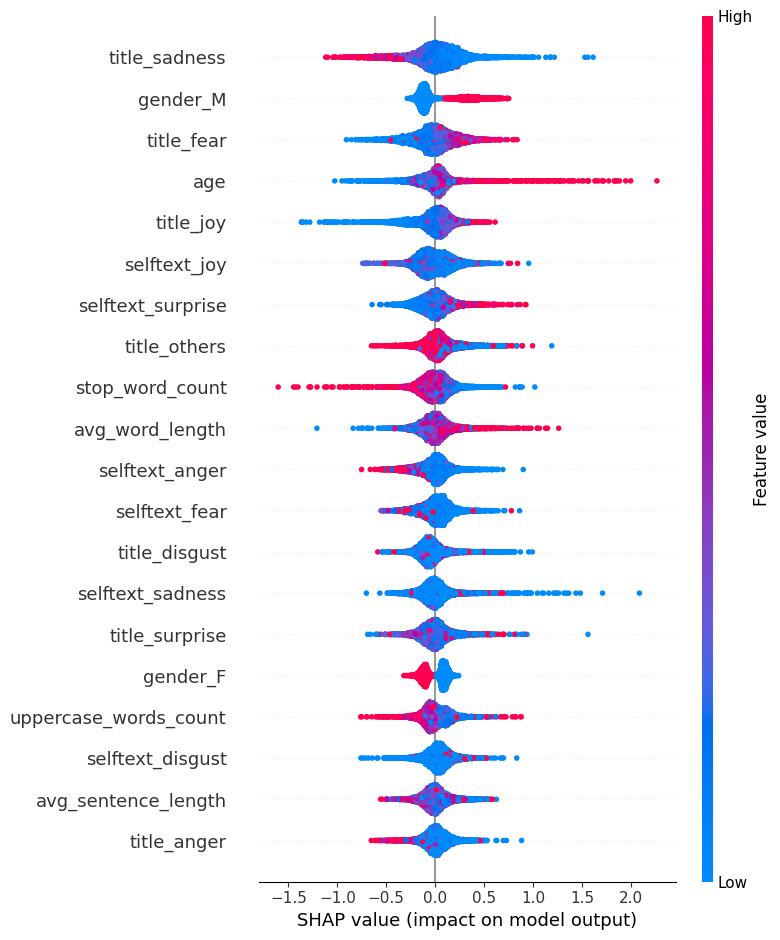

In [542]:
shap.summary_plot(shap_values, X_test)

In [543]:
pivot_table = pd.pivot_table(df[["is_asshole", "gender"]], index='is_asshole', columns='gender', aggfunc=len, fill_value=0)
pivot_table

gender,F,M,U
is_asshole,,,
0,27782,11965,18818
1,6165,4503,5425


In [544]:
df["age_floor"] = df.age.apply(lambda x: (x // 10) * 10)
pivot_table = pd.pivot_table(df[["is_asshole", "age_floor"]], index='is_asshole', columns='age_floor', aggfunc=len, fill_value=0)
pivot_table

age_floor,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0
is_asshole,,,,,,,,,
0,9623,16438,5526,1108,340,87,21,4,19
1,2213,4121,1578,444,162,58,8,4,5


In [545]:
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=0), axis=1) * 100
pivot_table_percentage

age_floor,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0
is_asshole,,,,,,,,,
0,81.302805,79.955251,77.787162,71.391753,67.729084,60.0,72.413793,50.0,79.166667
1,18.697195,20.044749,22.212838,28.608247,32.270916,40.0,27.586207,50.0,20.833333


In [546]:
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=0), axis=1) * 100
pivot_table_percentage

age_floor,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0
is_asshole,,,,,,,,,
0,81.302805,79.955251,77.787162,71.391753,67.729084,60.0,72.413793,50.0,79.166667
1,18.697195,20.044749,22.212838,28.608247,32.270916,40.0,27.586207,50.0,20.833333
